In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../../src/' ) # local version

from ml.preprocessing import *
from ml.constants import *

# Dataset Preparation

In [78]:
# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', '..', 'datasets' ]
out_path = [ '..', '..', '..', 'datasets', 'feature_selection', 'diff-hum-tem' ]

df = pd.read_csv( os.path.join( *path, 'ds-home-1sec.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )

In [79]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 3
    _MIN = 4

dfs = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

## Generating new datasets and features

In [80]:
%%time

def rename_col( name ):
    return name[ 0 ] + '_' + name[ 1 ]

# Minimal features dataset

dfs[ DF._MIN ] = resample_df( df, '10s' ).drop( columns = [ 'ven' ] )
# dfs[ DF._MIN ][ 'diff' ] = dfs[ DF._MIN ][ 'hum' ] - dfs[ DF._MIN ][ 'tem' ]
dfs[ DF._MIN ].to_csv( os.path.join( *out_path, 'fs-home-min.csv' ) )

# Extended featues dataset

dfs[ DF._FULL ] = resample_df_avg( df, '10s', [ 'mean', 'std', pd.DataFrame.kurt ] )
dfs[ DF._FULL ].columns = [ rename_col( c ) for c in dfs[ DF._FULL ].columns ]
dfs[ DF._FULL ][ 'diff_mean' ] = dfs[ DF._FULL ][ 'hum_mean' ] - dfs[ DF._FULL ][ 'tem_mean' ]
dfs[ DF._FULL ] = dfs[ DF._FULL ].rename( columns = { 'occ_mode': 'occ' } )

# swaping the two last columns order
# df_full reference is needed after splitting

df_full = dfs[ DF._FULL ] = dfs[ DF._FULL ][ 
    list( dfs[ DF._FULL ].columns[ :-2 ] ) + 
    [ dfs[ DF._FULL ].columns[ -1 ], dfs[ DF._FULL ].columns[ -2 ] ] ]

df_full.to_csv( os.path.join( *out_path, 'fs-home-full.csv' ) )
 

CPU times: user 55.8 s, sys: 485 ms, total: 56.3 s
Wall time: 56.2 s


## Normalizing and Balancing

In [83]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in dfs.items() :  
    if( k != DF._REDUCED_RFE and k != DF._REDUCED_KBEST ): 
        temp = list( split_data( d, test_size = 0.20 ) )
        temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )

        print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
        temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
            temp[ X_TRAIN ], 
            temp[ Y_TRAIN ], 
            neighbors[ k ] )
        print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
        print()

        dfs[ k ] = temp

Before balancing: DF._FULL Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._FULL Counter({'L': 16301, 'H': 16211, 'M': 16092, 'E': 15912})

Before balancing: DF._MIN Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._MIN Counter({'E': 16353, 'M': 16330, 'H': 16329, 'L': 16325})



In [84]:
df_full

,pre_mean,pre_std,pre_kurt,hum_mean,hum_std,hum_kurt,tem_mean,tem_std,tem_kurt,diff_mean,occ
date,,,,,,,,,,,
2020-05-14 21:08:40,94269.243000,1.630597,0.145379,54.499000,0.022336,0.116262,30.989000,0.003162,10.000000,23.510000,L
2020-05-14 21:08:50,94269.768889,2.106172,-1.687833,54.603333,0.116726,4.164892,30.986667,0.005000,-1.714286,23.616667,L
2020-05-14 21:09:00,94269.912000,1.007668,0.428097,54.891000,0.242003,-1.062457,30.988000,0.004216,1.406250,23.903000,L
2020-05-14 21:09:10,94270.447000,1.518677,-0.847210,54.286000,0.062397,1.293250,30.987000,0.004830,-1.224490,23.299000,L
2020-05-14 21:09:20,94271.049000,1.509315,1.848369,54.321000,0.158286,0.434056,30.998000,0.006325,0.178571,23.323000,L
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-04 23:08:10,94595.233333,0.871937,1.327502,56.377778,0.010929,-1.232172,31.947778,0.004410,0.734694,24.430000,M
2020-06-04 23:08:20,94595.986000,1.056201,1.598010,56.343000,0.009487,3.533216,31.950000,0.000000,0.000000,24.393000,M
2020-06-04 23:08:30,94595.866000,1.252022,-1.213272,56.345000,0.007071,0.571429,31.951000,0.003162,10.000000,24.394000,M


# Features Selection

In [85]:
from ml.feature_selection import *

## Recursive Feature Elimination 

In [86]:
x_train, x_test, y_train, y_test = dfs[ DF._FULL ]

selected_rfe = select_k_rfe( x_train, y_train, df_full.columns[ : -1 ], 5 )
selected_rfe

,rank,selected
pre_mean,1,1
hum_mean,1,1
hum_std,1,1
tem_mean,1,1
diff_mean,1,1
pre_kurt,2,0
tem_std,3,0
tem_kurt,4,0
hum_kurt,5,0
pre_std,6,0


In [89]:
dfs[ DF._REDUCED_RFE ] = df_full.drop( columns = selected_rfe.index[ 5: ] )
dfs[ DF._REDUCED_RFE ].to_csv( os.path.join( *out_path, 'fs-home-rfe.csv' ) )

## 3.2 Selecting K-best

In [90]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions( precision = 2 )

selected_kbest = select_k_best( x_train, y_train, df_full.columns[ : -1 ], 'all' )
selected_kbest

,score,p-value
tem_mean,"11,738.60",0.00
pre_mean,"8,286.61",0.00
diff_mean,"6,368.36",0.00
hum_mean,"4,708.84",0.00
hum_std,"1,113.86",0.00
pre_std,187.55,0.00
hum_kurt,161.92,0.00
pre_kurt,116.92,0.00
tem_std,36.11,0.00
tem_kurt,4.63,0.00


In [91]:
dfs[ DF._REDUCED_KBEST ] = df_full.drop( columns = selected_kbest.index[ 5: ] )
dfs[ DF._REDUCED_RFE ].to_csv( os.path.join( *out_path, 'fs-home-kbest.csv' ) )

## 3.3 Feature Correlation

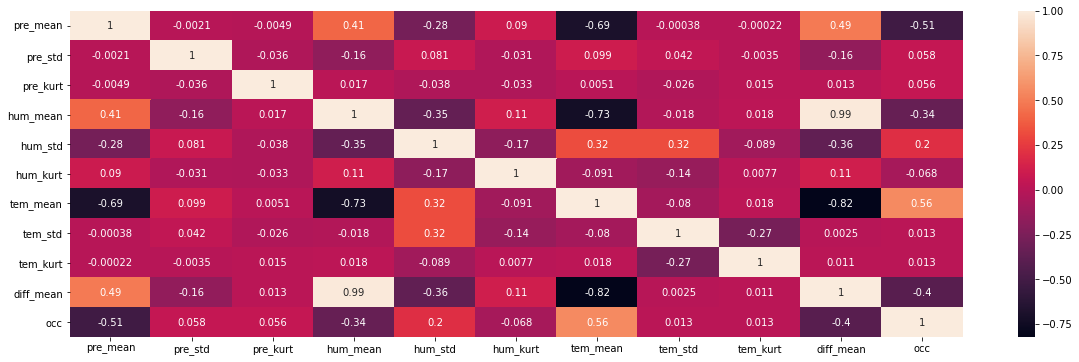

In [92]:
temp = np.concatenate( ( x_train, y_train.replace( { 'E': 0, 'L':1, 'M':2, 'H':3 } ).values.reshape( len( y_train ), 1 ) ), axis = 1 )
temp = pd.DataFrame( data = temp, columns = df_full.columns )

plt.subplots( 1, 1, figsize = ( 20, 6 ) )
sns.heatmap( temp.corr(), annot = True )

It is necessary to remove highly correlated values